In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import face_recognition
from sklearn import svm
import os

In [3]:
"""
Structure:
        <test_image>.jpg
        <train_dir>/
            <person_1>/
                <person_1_face-1>.jpg
                <person_1_face-2>.jpg
                .
                .
                <person_1_face-n>.jpg
           <person_2>/
                <person_2_face-1>.jpg
                <person_2_face-2>.jpg
                .
                .
                <person_2_face-n>.jpg
            .
            .
            <person_n>/
                <person_n_face-1>.jpg
                <person_n_face-2>.jpg
                .
                .
                <person_n_face-n>.jpg
""";

In [4]:
encodings = []
names = []

train_dir = os.listdir('faces/')

# loop through each person in the directory
i=1
for person in train_dir:
    pix  = os.listdir('faces/' + person)
    
    # loop through each training image for the current person
    for person_img in pix:
        # get the face encodings for the face in each image file
        face = face_recognition.load_image_file('faces/'+person+'/'+person_img)
        face_bounding_boxes = face_recognition.face_locations(face)

        #If training image contains exactly one face
        if len(face_bounding_boxes) == 1:
            face_enc = face_recognition.face_encodings(face)[0]
            # Add face encoding for current image with corresponding label (name) to the training data
            encodings.append(face_enc)
            names.append(person)
        else:
            print(str(i)+"."+person + "/" + person_img + " was skipped and can't be used for training")
            i+=1

1.insta_10/4.png was skipped and can't be used for training
2.mostafa_mohamed_bue/3.png was skipped and can't be used for training
3.mostafa_mohamed_bue/2.png was skipped and can't be used for training
4.norhan/3.png was skipped and can't be used for training
5.norhan/5.png was skipped and can't be used for training
6.insta_6/4.png was skipped and can't be used for training
7.alaa/3.png was skipped and can't be used for training
8.insta_8/2.png was skipped and can't be used for training
9.insta_8/1.png was skipped and can't be used for training
10.insta_7/3.png was skipped and can't be used for training
11.insta_7/5.png was skipped and can't be used for training
12.insta_7/1.png was skipped and can't be used for training
13.mahmoud_nabil/0.png was skipped and can't be used for training
14.insta_4/4.png was skipped and can't be used for training
15.eslam/3.png was skipped and can't be used for training
16.insta_1/4.png was skipped and can't be used for training
17.insta_1/1.png was skip

In [5]:
# create and train the svc classifier
clf = svm.SVC(gamma='scale')
clf.fit(encodings, names)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [6]:
# load the test image with unknown faces into a numpy array
test_image = face_recognition.load_image_file('imgs/moaz.jpg')

# find all the faces in the test image using the defualt HOG-based model
face_locations = face_recognition.face_locations(test_image)
no = len(face_locations)

print(f'Number of faces detected: {no}')

Number of faces detected: 1


In [7]:
# predict all faces in the test image using the trained classifier
print('Found:')
for i in range(no):
    test_image_enc = face_recognition.face_encodings(test_image)[i]
    name = clf.predict([test_image_enc])
    print(name[0])

Found:
moaz


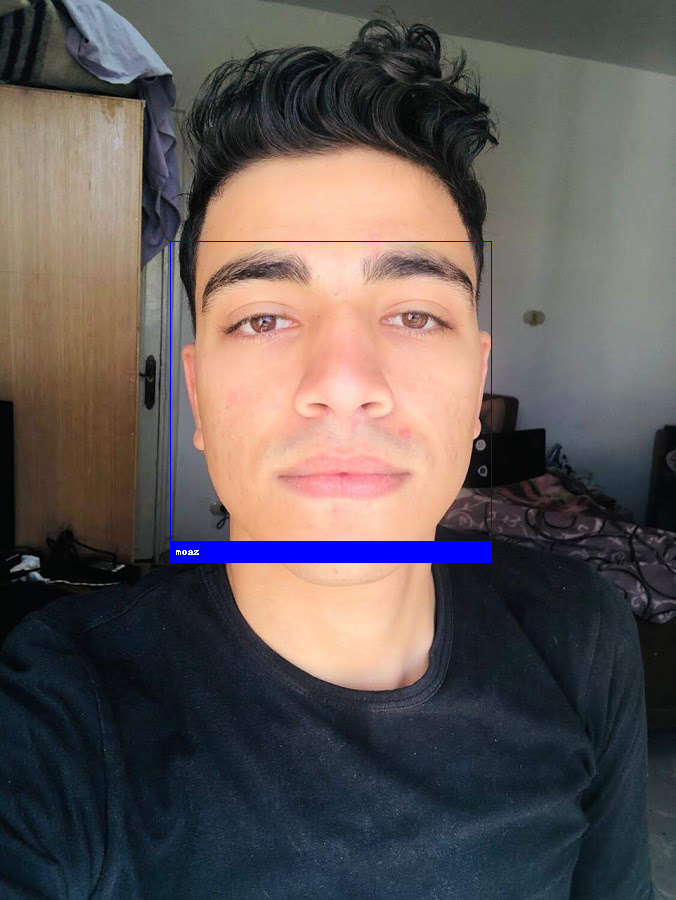

In [8]:
from PIL import Image, ImageDraw
import numpy as np

# Convert the image to a PIL-format image so that we can draw on top of it with the Pillow library
# See http://pillow.readthedocs.io/ for more about PIL/Pillow
pil_image = Image.fromarray(test_image)
# Create a Pillow ImageDraw Draw instance to draw with
draw = ImageDraw.Draw(pil_image)


i=0
for top, right, bottom, left in face_locations:
    test_image_enc = face_recognition.face_encodings(test_image)[i]
    name = clf.predict([test_image_enc])
    name = str(name[0])
     
    # Draw a box around the face using the Pillow module
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))
    
    # Draw a label with a name below the face
    text_width, text_height = draw.textsize(name)
    
    draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
    draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))
    i += 1
# Remove the drawing library from memory as per the Pillow docs
del draw

# Display the resulting image
display(pil_image)

# Live feed

In [15]:
import cv2



process_this_frame = True
# Get a reference to webcam #0 (the default one)
video_capture = cv2.VideoCapture(0)


while True:
    ret, frame = video_capture.read()
    
    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    
    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = small_frame[:, :, ::-1]
    
    if process_this_frame:
        # Find all the faces and face encodings in the current frame of video
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)
        
        face_names = []
        for face_encoding in face_encodings:
            name = clf.predict([face_encoding])
            face_names.append(name[0])
            
    process_this_frame = not process_this_frame
    
    # Display the results
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        # Scale back up face locations since the frame we detected in was scaled to 1/4 size
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        # Draw a box around the face
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

        # Draw a label with a name below the face
        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

    # Display the resulting image
    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()